# Notebook to see RV residuals for different Template Scenarios: NO TELLURICS

In [9]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm
from astropy.time import Time
from scipy.signal import find_peaks
import PyAstronomy.pyasl as pya 
from astropy import constants as const
from stellar import StellarSpectrum
from observations import Observations
from process import Process
from template import Template
from convolution import *
from interpolater import *
from scipy.signal import argrelextrema
from vfinder import Velocity_Finder

# Define Key Variables

In [10]:
SNR = 1e5 # SNR of individual observations
K_amp = 5 # K amplitude of single planetary signal
date_seed = 43
''' Parameters to determine Native Resolution of PHOENIX spectra '''
R_start = 200_000 # Original "broadening" factor of PHOENIX spectra
oversample = 5 # Oversampling factor of PHOENIX spectra
# The native resolution is then R_start*oversample

''' Parameters to determine Instrument Resolution '''
inst_res = 70_000 # Broadening factor added to observations by instrument
use_inst_wgrid = True # Are you going to downgrade spectra to an instrument resolution
use_spirou_wgrid = True # Are you going to use exactly spirou's grid or a constant resolution grid based off of a spirou order
inst_resolution = 150_000

# Define the Base Stellar Spectrum

In [11]:
# Define the spectrum
stellar = StellarSpectrum(starting_resolution=R_start,oversample=oversample)#,T=3000,logg=5,metal=0)

# We are going to immediately change this flux into a specific SNR flux
# This is valid because we do not bin into instrument wavelegth grid, we will interpolate to the instrument wavelength grid
stellar.incorporate_SNR(SNR, use_inst_wgrid,inst_resolution)

array([2.35806859e+10, 2.45713731e+10, 2.54353878e+10, ...,
       7.99104428e+09, 6.68464345e+09, 5.77338819e+09])

Text(0.5, 0, 'Wavelength (nm)')

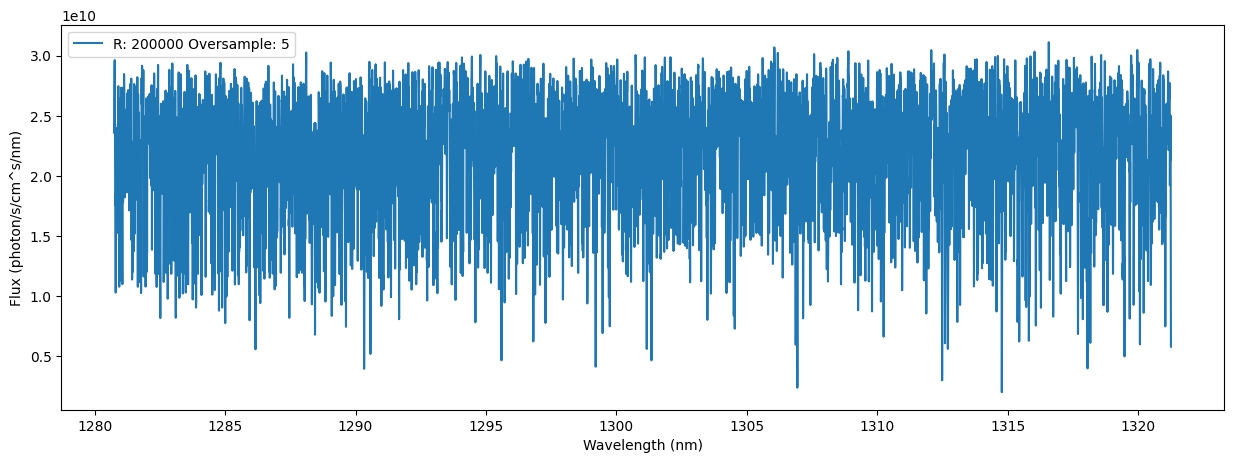

In [12]:
plt.figure(figsize=(15,5))
plt.plot(stellar.phoenix_wgrid,stellar.stellar,label="R: "+str(R_start)+" Oversample: "+str(oversample))
# plt.xlim(1290,1291)
plt.ylabel("Flux (photon/s/cm^s/nm)")
plt.legend()
plt.xlabel("Wavelength (nm)")

# Define the RV Curve
To make the RV curve as realistic as possible, we will observe over a continous period that has some gaps and the observations won't be perfectly equally spaced from one another.
To avoid template anchoring issues, we will create 200 observations. The first 100 points are going to be reserved as "template" points, these will be the ones we use for the template points. Therefore in this setup you can't use more than 100 observations to create a template. Then you can use the other 100 points to evaluate how well your template is doing. Currently we will just use 20 points that are spread out over the back end of the RV curve.

In [13]:
# Define the observations object
observations = Observations(native_wavegrid=stellar.phoenix_wgrid,instrument_wavegrid=stellar.inst_wgrid,num=200)

# Define the dates
start_date = '2020-01-01'
end_date = '2021-01-03'
dates = observations.dates(start_date,end_date,seed=date_seed)

# Define the curve
RV, planet = observations.RV_signal(planet_amp=K_amp)

Text(0.5, 0, 'Julian Dates')

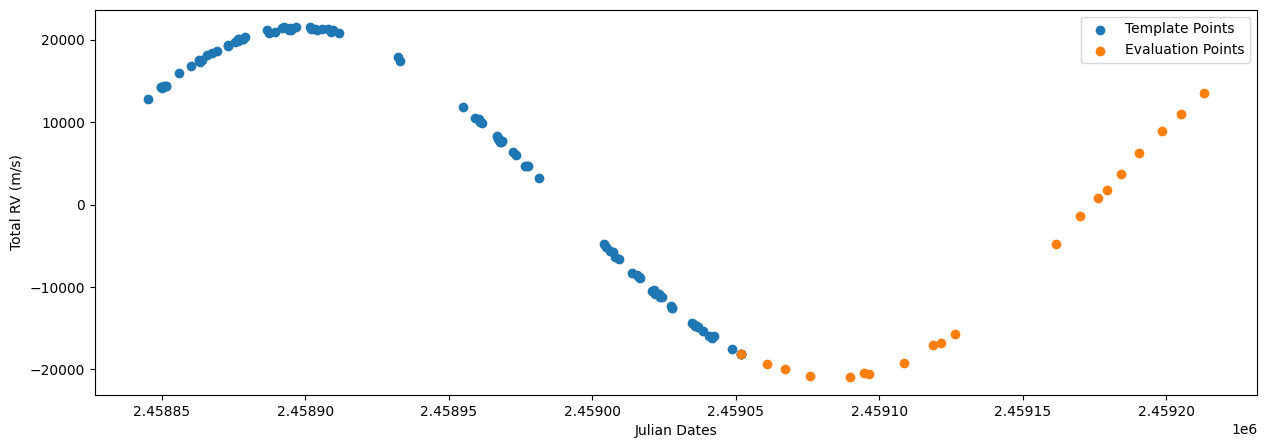

In [14]:
plt.figure(figsize=(15,5))
plt.scatter(observations.julian_dates[:100],observations.RV[:100],label="Template Points")
plt.scatter(observations.julian_dates[100:][::5],observations.RV[100:][::5],label="Evaluation Points")


plt.ylabel("Total RV (m/s)")
plt.legend()
plt.xlabel("Julian Dates")

Text(0.5, 0, 'Julian Dates')

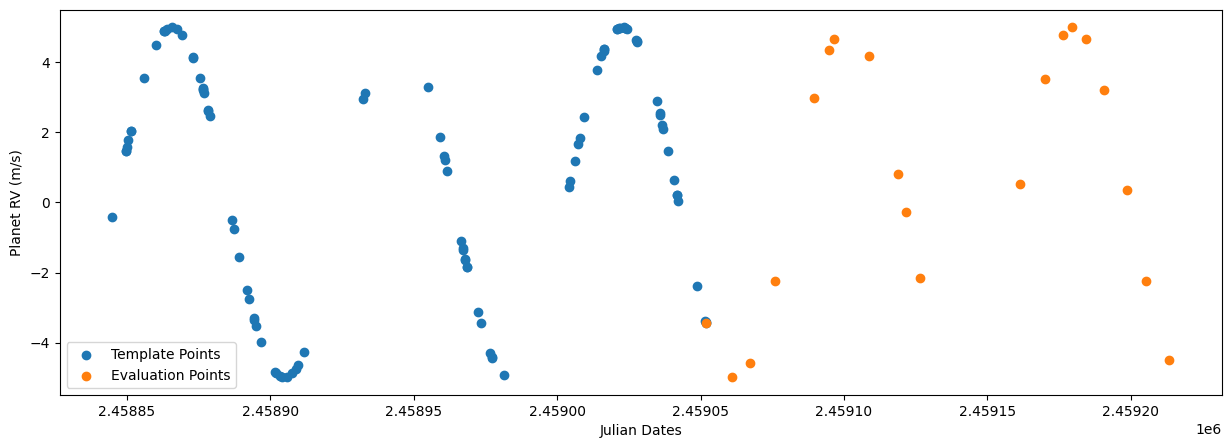

In [15]:
plt.figure(figsize=(15,5))
plt.scatter(observations.julian_dates[:100],observations.planet[:100],label="Template Points")
plt.scatter(observations.julian_dates[100:][::5],observations.planet[100:][::5],label="Evaluation Points")


plt.ylabel("Planet RV (m/s)")
plt.legend()
plt.xlabel("Julian Dates")

# Create the Observations

In [16]:
# Doppler shift them
shifted = observations.doppler_shift(stellar.stellar)

# Put into Instrument Resolution 
inst_wgrid, inst_spec, convolved = observations.instrument_captures(inst_res,use_inst_wgrid,use_spirou_wgrid,new_res=inst_resolution)

# Create noisy observations
noisy, sig = observations.poisson(seed=10)

In [17]:
1/(np.diff(inst_wgrid)/inst_wgrid[1:])

array([115122.01120127, 115129.20102477, 115136.39153947, ...,
       151869.37062695, 151880.67860572, 151891.98801206])

# Post Process the Data (Turned off since did not include tellurics)

In [18]:
processor = Process(observations.instrument_wgrid,observations.instrument_spectra)

# Remove tellurics 
# _ = processor.remove_tellurics(corrected_model_tellurics[0],inst_res,observations.instrument_wgrid,stellar.phoenix_wgrid)


# Remove low flux regions
# _ = processor.remove_bad_regions()

# Create the Template

In [19]:
# Number of epochs used to create the template
T_epochs = [2, 20, 100]
templates = []

for T in T_epochs:
    # We will only create the template out of T observations 
    
    # The template will be placed in an upsampled space, this will just be kept as the native (original)
    # grid of the observations to make it easy for comparison of the interpolation issue
    template_maker = Template(observations.berv[:100][::int(100/T)], upsampled_wgrid = observations.native_wgrid, inst_wgrid = observations.instrument_wgrid)

    # Shift the observations back by their berv
    shiftedflux, upsampledflux = template_maker.shift_back_by_bervs(processor.spectra[:100][::int(100/T)])

    # Take the median of these observations
    template = template_maker.create_template()

    templates.append(template)


# Make a plot of each step

In [20]:
# Which observations are you following
o = 0

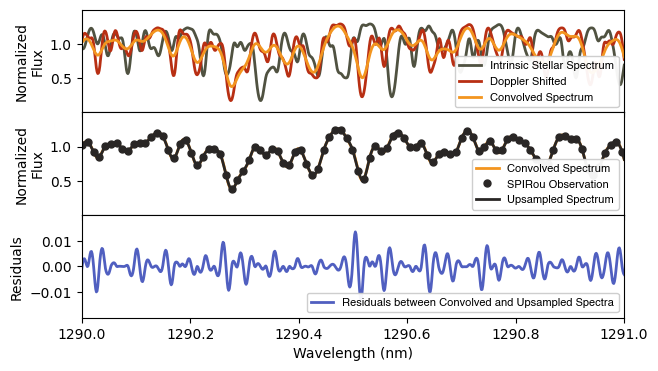

In [21]:
fig, axs = plt.subplots(3,1,figsize=(7,4),sharex=True)
colors = ['#505FC0', '#b82f13', '#f3951f', '#505241', '#88a66e', '#292625']
# colors =  ['#4E5BAF', '#C3411F', '#E18D2D', '#5A5E48', '#7DA46D', '#2C2A28']

plt.rcParams["font.family"] = "Helvetica"
# plt.tight_layout()
plt.subplots_adjust(hspace=0)
axs[0].plot(stellar.phoenix_wgrid,stellar.stellar/np.median(stellar.stellar),label="Intrinsic Stellar Spectrum",c=colors[3],lw=2)
axs[0].plot(stellar.phoenix_wgrid,shifted[o]/np.median(stellar.stellar),label="Doppler Shifted",c=colors[1],lw=2)
axs[0].plot(stellar.phoenix_wgrid,convolved[o]/np.median(stellar.stellar),label="Convolved Spectrum",c=colors[2],lw=2)
axs[0].legend(loc="lower right",fontsize=8,framealpha=0.95)
axs[1].plot(stellar.phoenix_wgrid,convolved[o]/np.median(stellar.stellar),label="Convolved Spectrum",c=colors[2],lw=2)
axs[1].plot(observations.instrument_wgrid,inst_spec[o]/np.median(stellar.stellar),label="SPIRou Observation",c=colors[-1],ls="",marker="o",markersize=5)
axs[1].plot(observations.native_wgrid,upsampledflux[o]/np.median(stellar.stellar),label="Upsampled Spectrum",c=colors[-1],lw=2)
axs[1].legend(loc="lower right",fontsize=8,framealpha=0.95)
axs[2].plot(stellar.phoenix_wgrid,(convolved[o]-upsampledflux[o])/np.median(stellar.stellar),label="Residuals between Convolved and Upsampled Spectra",c=colors[0],lw=2)
axs[2].set_xlim(1290,1291)
axs[2].legend(loc="lower right",fontsize=8,framealpha=0.95)
axs[0].set_ylabel("Normalized\nFlux",fontsize=10)
axs[1].set_ylabel("Normalized\nFlux",fontsize=10)
axs[2].set_ylabel("Residuals",fontsize=10)
axs[2].set_xlabel("Wavelength (nm)",fontsize=10)
axs[0].set_ylim(0,1.5)
axs[1].set_ylim(0,1.5)
axs[2].set_ylim(-0.02,0.02)
axs[0].set_yticks([0.5,1])
axs[1].set_yticks([0.5,1])
axs[2].set_yticks([-0.01,0,0.01])

# plt.savefig("interp_relative.pdf")

# Now let's find the RVs

In [22]:
evaluation_points = np.arange(0,200,1)[100:][::5]
# General uncertainty for SPIROU rv is 1m/s
dvs = 1e-3

## Let's first find it for the templates

In [23]:
template_retrieved_RVs = np.zeros((3,20))
template_uncs = np.zeros((3,20))

# Iterate through each template
for k,template in enumerate(templates):
    retrieved = np.zeros(20)
    uncs =  np.zeros(20)

    # Iterate through each evaluation point
    for j,o in enumerate(evaluation_points):
        # First we will just shift the template by berv
        total_shift = observations.berv[o]
        iterated_RVs = np.zeros(5)

        # Find the planet RV iteratively
        for i in range(5):
            # Define the finder object
            vf = Velocity_Finder(template,observations.native_wgrid,observations.instrument_wgrid,total_shift,False,T_epochs=T_epochs[k])

            # Determine the RV
            RV, uncRV = vf.find_dv(processor.spectra[o],dvs,sig[o])

            # Next time we will shift the template by the berv plus this additional RV
            total_shift+=RV[0]
            iterated_RVs[i] = RV[0]
            if RV<=0.001:
                break
                
        # Determine the uncertainty after you found the RV
        uncRV = vf.find_unc(processor.spectra[o],sig[o],np.sum(iterated_RVs),dvs)

        template_retrieved_RVs[k][j] = np.sum(iterated_RVs)
        template_uncs[k][j] = uncRV[0]

/var/folders/vw/5qpldskx1hn6wrghx5fk63v40000gn/T/ipykernel_9069/1863525040.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  template_uncs[k][j] = uncRV


## Now for the base

In [24]:
base_retrieved = np.zeros(20)
base_uncs = np.zeros(20)
# Iterate through each evaluation point
for j,o in enumerate(evaluation_points):
    # First we will just shift the template by berv
    total_shift = observations.berv[o]
    iterated_RVs = np.zeros(5)

    # Find the planet RV iteratively
    for i in range(5):
        # Define the finder object
        vf = Velocity_Finder(stellar.stellar,observations.native_wgrid,observations.instrument_wgrid,total_shift,True,inst_res)

        # Determine the RV
        RV, uncRV = vf.find_dv(processor.spectra[o],dvs,sig[o])

        # Next time we will shift the template by the berv plus this additional RV
        total_shift+=RV[0]
        iterated_RVs[i] = RV[0]
        if RV<=0.001:
            break
            
    # Determine the uncertainty after you found the RV
    uncRV = vf.find_unc(processor.spectra[o],sig[o],np.sum(iterated_RVs),dvs)

    base_retrieved[j] = np.sum(iterated_RVs)
    base_uncs[j] = uncRV[0]

/var/folders/vw/5qpldskx1hn6wrghx5fk63v40000gn/T/ipykernel_9069/220615723.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base_uncs[j] = uncRV


# Let's see how well the RVs are

In [25]:
from scipy.optimize import curve_fit
def sine_function(x, A, D):
    return A * np.sin(0.08*x) + D
initial_guess = [50,0]

In [26]:
# Fit the retrieved RVs to a Sin curve and see if we retrieve the right K amplitude (assume we know the frequency)

params = np.zeros((4,2))
unc_params = np.zeros((4,2))

for i in range(4):
    if i==3:
        variables, params_covariance = curve_fit(sine_function, observations.julian_dates[100:][::5], base_retrieved, p0=initial_guess,sigma=base_uncs,absolute_sigma=True)
        params[i] = variables
        unc_params[i][0] = params_covariance[0][0]
        unc_params[i][1] = params_covariance[1][1]

    else:
        variables, params_covariance = curve_fit(sine_function, observations.julian_dates[100:][::5], template_retrieved_RVs[i], p0=initial_guess,sigma=template_uncs[i],absolute_sigma=True)
        params[i] = variables
        unc_params[i][0] = params_covariance[0][0]
        unc_params[i][1] = params_covariance[1][1]


In [27]:
# Calculate the weighted chis
real = observations.planet[100:][::5]

# Take out the overall shift factor when calculating chi2
chis = []
for i in range(4):
    if i==3:
        chis.append(np.sqrt(np.mean((real-(base_retrieved-params[i][1]))**2)))
    else:
        chis.append(np.sqrt(np.mean((real-(template_retrieved_RVs[i]-params[i][1]))**2)))

Text(0.5, 0, 'Julian Dates')

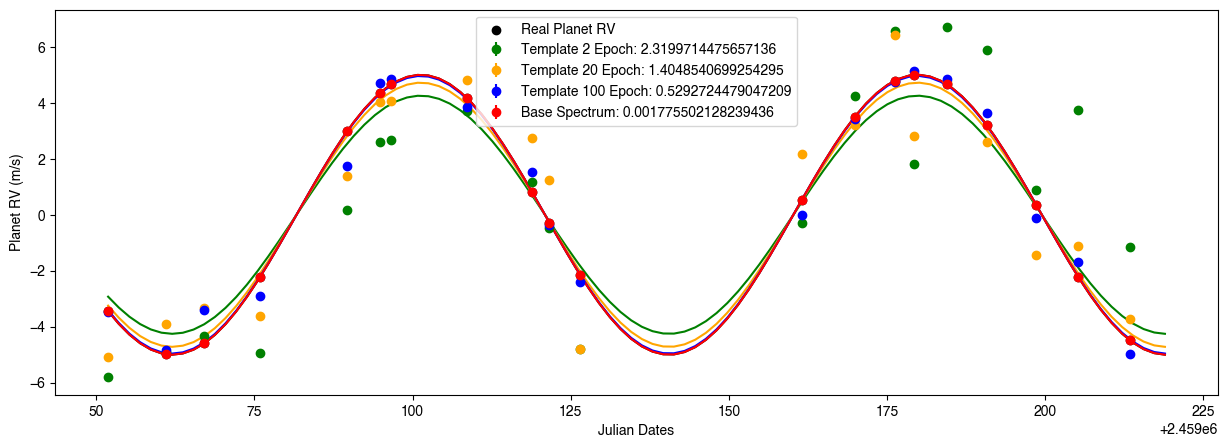

In [28]:
x = np.linspace(observations.julian_dates[100],observations.julian_dates[-1],100)

plt.figure(figsize=(15,5))
plt.scatter(observations.julian_dates[100:][::5],observations.planet[100:][::5],label="Real Planet RV",color="k")
plt.plot(x,sine_function(x,K_amp,0),color="k")

colors = ['green','orange','blue','red']

for i in range(4):

    if i==3:
        plt.errorbar(observations.julian_dates[100:][::5],base_retrieved-params[i][1],base_uncs[1],
                label="Base Spectrum: "+str(chis[i]),ls="",marker="o",color=colors[i])
        plt.plot(x,sine_function(x,params[i][0],0),color=colors[i])
        
    else:
        plt.errorbar(observations.julian_dates[100:][::5],template_retrieved_RVs[i]-params[i][1],template_uncs[1],
                label="Template "+str(T_epochs[i])+" Epoch: "+str(chis[i]),ls="",marker="o",color=colors[i])
        plt.plot(x,sine_function(x,params[i][0],0),color=colors[i])
        
plt.legend()
plt.ylabel("Planet RV (m/s)")
plt.xlabel("Julian Dates")